In [69]:
import os
from pathlib import Path
import mido
from mido import MidiFile, MidiTrack, MetaMessage, Message
import numpy as np
from pretty_midi import PrettyMIDI
import random
from matplotlib import pyplot as plt

from rich import print
from rich.layout import Layout

In [58]:
def plot_images(
    images,
    titles,
    shape = None,
    main_title = None,
    set_axis: str = "off",
) -> None:
    """Plot images vertically"""
    num_images = len(images)

    if shape is None:
        shape = [num_images, 1]

    plt.style.use("dark_background")
    plt.figure(figsize=(12, 12))

    if main_title:
        plt.suptitle(main_title)
    for num_plot in range(num_images):
        plt.subplot(shape[0], shape[1], num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        plt.title(titles[num_plot])
        plt.axis(set_axis)
    plt.show()

In [59]:
def get_note_min_max(input_file_path):
    mid = MidiFile(input_file_path)

    lowest_note = 127
    highest_note = 0

    for track in mid.tracks:
        for msg in track:
            if not msg.is_meta and msg.type in ['note_on', 'note_off']:
                # Update lowest and highest note if this is a note_on message
                if msg.velocity > 0:  # Considering note_on messages only
                    lowest_note = min(lowest_note, msg.note)
                    highest_note = max(highest_note, msg.note)
    
    return lowest_note, highest_note

In [84]:
def transpose_midi(input_file_path, output_file_path, semitones):
    """
    Transposes all the notes in a MIDI file by a specified number of semitones.
    
    Args:
    - input_file_path: Path to the input MIDI file.
    - output_file_path: Path where the transposed MIDI file will be saved.
    - semitones: Number of semitones to transpose the notes. Positive for up, negative for down.
    """
    midi = PrettyMIDI(input_file_path)
    print(f"shifting notes by {semitones} semitones")
    for instrument in midi.instruments:
        # Don't want to shift drum notes
        if not instrument.is_drum:
            for note in instrument.notes:
                note.pitch += semitones
    midi.write(output_file_path)

In [61]:
def alternate_count(max_up, max_down, iter):
    """chatgpt"""
    results = []
    up = 1
    down = -1
    for i in range(iter):
        if i % 2 == 0:
            if up > max_up:  # If exceeding max_up, adjust by switching to down immediately
                results.append(down)
                down -= 1
            else:
                results.append(up)
                up += 1
        else:
            if abs(down) > max_down:  # If exceeding max_down, adjust by switching to up immediately
                results.append(up)
                up += 1
            else:
                results.append(down)
                down -= 1
    return results

In [89]:
def semitone_shift(filepath, output_dir, num_iterations: int = 1):
    """vertically shift a matrix
    """
    lowest_note, highest_note = get_note_min_max(filepath)
    max_up = 108 - highest_note # TODO double-check this
    max_down = lowest_note

    # zipper up & down
    up = 1
    down = -1
    for i in range(num_iterations):
        up_filename = f"{Path(filepath).stem}_u{up:02d}.mid"
        down_filename = f"{Path(filepath).stem}_d{abs(down):02d}.mid"
        
        if i % 2 == 0:
            if up > max_up:  # If exceeding max_up, adjust by switching to down immediately
                transpose_midi(filepath, os.path.join(output_dir, down_filename), down)
                down -= 1
            else:
                transpose_midi(filepath, os.path.join(output_dir, up_filename), up)
                up += 1
        else:
            if abs(down) > max_down:  # If exceeding max_down, adjust by switching to up immediately
                transpose_midi(filepath, os.path.join(output_dir, up_filename), up)
                up += 1
            else:
                transpose_midi(filepath, os.path.join(output_dir, down_filename), down)
                down -= 1

In [91]:
num_semitones = 8
out_dir = "tmp"

for file in os.listdir(out_dir):
    os.remove(os.path.join(out_dir, file))

semitone_shift(os.path.join("..", "inputs", "test datasets", "octaveC-70-01.mid"), out_dir, num_semitones)

shifting notes by 1 semitones

shifting notes by -1 semitones

shifting notes by 2 semitones

shifting notes by -2 semitones

shifting notes by 3 semitones

shifting notes by -3 semitones

shifting notes by 4 semitones

shifting notes by -4 semitones

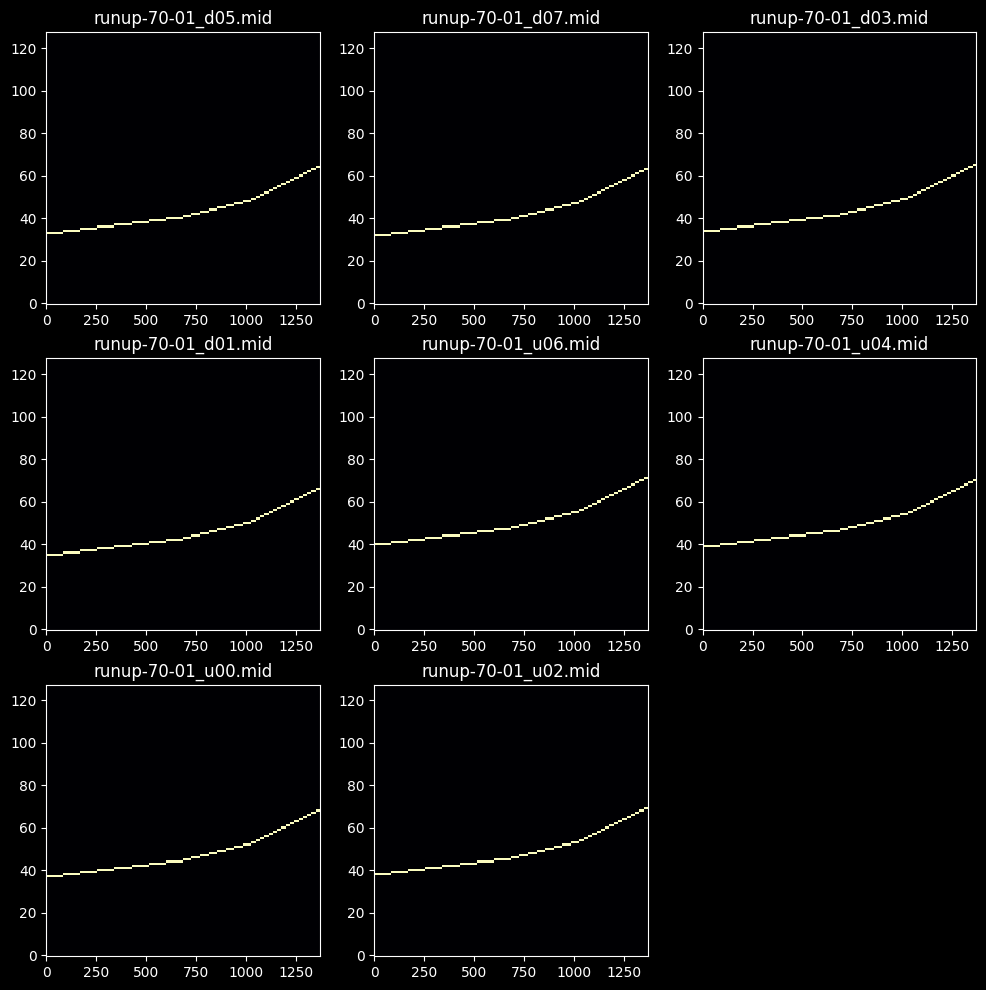

In [82]:
prs = []
titles = []
for file in os.listdir(out_dir):
    file_path = os.path.join(out_dir, file)
    prs.append(PrettyMIDI(file_path).get_piano_roll())
    titles.append(file)
plot_images(prs, titles, [3, 3], set_axis="on")

In [21]:
def shift_array(arr, up=0, down=0):
    """Shift array vertically within bounds"""
    if up > 0:
        arr = np.roll(arr, -up, axis=0)
        arr[-up:] = 0
    elif down > 0:
        arr = np.roll(arr, down, axis=0)
        arr[:down] = 0
    return arr

In [22]:
def vertical_shift(array, name: str, num_iterations: int = 1, do_shuffle: bool = False):
    """vertically shift a matrix
    """
    shifted_matrices = []

    rows_with_non_zero = np.where(array.any(axis=1))[0]
    maximum_up = array.shape[0] - rows_with_non_zero[-1] - 1
    maximum_down = rows_with_non_zero[0]

    # zipper up & down
    for i in range(1, num_iterations):
        if i < maximum_up:
            shifted_matrices.append((f"{Path(name).stem}_u{i:02d}", np.copy(shift_array(array, down=i))))
        else:
            shifted_matrices.append((f"{Path(name).stem}_d{i:02d}", np.copy(shift_array(array, up=i))))

        if i < maximum_down:
            shifted_matrices.append((f"{Path(name).stem}_d{i:02d}", np.copy(shift_array(array, up=i))))
        else:
            shifted_matrices.append((f"{Path(name).stem}_u{i:02d}", np.copy(shift_array(array, down=i))))

    if do_shuffle:
        random.shuffle(shifted_matrices)

    return shifted_matrices[:num_iterations]

In [ ]:
data_dir = os.path.join("..", "inputs", "test datasets")
file = os.path.join(data_dir, "amfamf-70-03.mid")
num_semitones = 12

titles, prs = zip(*vertical_shift(PrettyMIDI(file).get_piano_roll(), "test", num_semitones))
plot_images(prs, titles, [4, 3], set_axis="on")

In [78]:
out_port = "to Max 1"
messages = [
    MetaMessage('set_tempo', tempo=mido.bpm2tempo(70), time=0),
    MetaMessage('track_name', name='octaveC-70-01', time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=36, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=36, notated_32nd_notes_per_beat=8, time=0),
    Message('note_on', channel=0, note=60, velocity=60, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=78, time=0),
    Message('note_on', channel=0, note=60, velocity=66, time=96),
    Message('note_off', channel=0, note=72, velocity=58, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=81, time=0),
    Message('note_on', channel=0, note=60, velocity=60, time=96),
    Message('note_off', channel=0, note=72, velocity=61, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=78, time=0),
    Message('note_on', channel=0, note=60, velocity=66, time=96),
    Message('note_off', channel=0, note=72, velocity=58, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=81, time=0),
    Message('note_on', channel=0, note=60, velocity=60, time=96),
    Message('note_off', channel=0, note=72, velocity=61, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=78, time=0),
    Message('note_on', channel=0, note=60, velocity=66, time=96),
    Message('note_off', channel=0, note=72, velocity=58, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=81, time=0),
    Message('note_on', channel=0, note=60, velocity=60, time=96),
    Message('note_off', channel=0, note=72, velocity=61, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=78, time=0),
    Message('note_on', channel=0, note=60, velocity=66, time=96),
    Message('note_off', channel=0, note=72, velocity=58, time=0),
    Message('note_off', channel=0, note=60, velocity=58, time=96),
    Message('note_on', channel=0, note=72, velocity=81, time=0),
    Message('note_off', channel=0, note=72, velocity=61, time=96),
    MetaMessage('end_of_track', time=0)
]

og_mid = MidiFile()
sh_mid = MidiFile()
og_track = MidiTrack()
sh_track = MidiTrack()
og_mid.tracks.append(og_track)
sh_mid.tracks.append(sh_track)

for message in messages:
    og_track.append(message)

    if message.is_meta:
        sh_track.append(message)
    else:
        sh_msg = Message(type=message.type, 
                         note=message.note + 12, 
                         velocity=message.velocity, 
                         channel=message.channel,
                         time=message.time)
        sh_msg.note = message.note + 12
        sh_track.append(sh_msg)
sh_mid.print_tracks()
og_mid.print_tracks()
og_mid.save('og_mido.mid')
sh_mid.save('sh_mido.mid')

with mido.open_output(out_port) as outport: # type: ignore
    print('starting')
    for msg in og_mid.play():
        outport.send(msg)

    print('done')
    print('starting')
    for msg in sh_mid.play():
        outport.send(msg)
    print('done')

=== Track 0
MetaMessage('set_tempo', tempo=857143, time=0)
MetaMessage('track_name', name='octaveC-70-01', time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=36, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=36, notated_32nd_notes_per_beat=8, time=0)
Message('note_on', channel=0, note=72, velocity=60, time=0)
Message('note_off', channel=0, note=72, velocity=58, time=96)
Message('note_on', channel=0, note=84, velocity=78, time=0)
Message('note_on', channel=0, note=72, velocity=66, time=96)
Message('note_off', channel=0, note=84, velocity=58, time=0)
Message('note_off', channel=0, note=72, velocity=58, time=96)
Message('note_on', channel=0, note=84, velocity=81, time=0)
Message('note_on', channel=0, note=72, velocity=60, time=96)
Message('note_off', channel=0, note=84, velocity=61, time=0)
Message('note_off', channel=0, note=72, velocity=58, time=96)
Message('note_on', channel=0, note=84, 

starting

done

starting

done